# 1. Importing modules and functions

In [81]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [3]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [4]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [5]:
uploaded_file_ws="datasets/HDAC3_work.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  1400 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [6]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [7]:
len(y_tr)

1400

# 3.Standardization SDF file for work set

In [8]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  1400 molecules


In [9]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [10]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [11]:
uploaded_file_ts="datasets/HDAC3_test.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pchembl_value_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  351 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [12]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [13]:
len(y_ts)

351

# 5.Standardization SDF file for test set

In [14]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  351 molecules


In [15]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [16]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [17]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

### KlekotaRoth FPs

In [18]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [23]:
descriptors_KlekotaRoth = pd.read_csv('KlekotaRoth.csv')

In [24]:
descriptors_KlekotaRoth

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
0,AUTOGEN_molecule_ws_1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,AUTOGEN_molecule_ws_1396,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396,AUTOGEN_molecule_ws_1397,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,AUTOGEN_molecule_ws_1398,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1398,AUTOGEN_molecule_ws_1399,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
descriptors_KlekotaRoth[descriptors_KlekotaRoth['KRFP1236']==1]

,Name,KRFP1,KRFP2,KRFP3,KRFP4,KRFP5,KRFP6,KRFP7,KRFP8,KRFP9,...,KRFP4851,KRFP4852,KRFP4853,KRFP4854,KRFP4855,KRFP4856,KRFP4857,KRFP4858,KRFP4859,KRFP4860
213,AUTOGEN_molecule_ws_214,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
698,AUTOGEN_molecule_ws_699,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
712,AUTOGEN_molecule_ws_713,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
752,AUTOGEN_molecule_ws_753,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
817,AUTOGEN_molecule_ws_818,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1394,AUTOGEN_molecule_ws_1395,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1395,AUTOGEN_molecule_ws_1396,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1396,AUTOGEN_molecule_ws_1397,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1397,AUTOGEN_molecule_ws_1398,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
descriptors_ws = descriptors_KlekotaRoth.drop('Name', axis=1)

In [28]:
x_tr = np.array(descriptors_ws, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [29]:
savetxt('Models/Padels/x_tr_KlekotaRoth.csv', x_tr, delimiter=',')

In [30]:
x_tr.shape

(1400, 4860)

# 7.Descriptor calculation for test set

In [ ]:
from padelpy import padeldescriptor

fingerprint = 'KlekotaRoth'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [31]:
descriptors_KlekotaRoth_ts = pd.read_csv('KlekotaRoth_ts.csv')

In [32]:
x_ts = descriptors_KlekotaRoth_ts.drop('Name', axis=1)

In [33]:
desc_ts=x_ts

In [34]:
x_ts.shape

(351, 4860)

 # BASELINE GradientBoostingRegressor

In [35]:
seed = 42

In [36]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [37]:
param_grid = {'learning_rate': [0.01, 0.04],
                  'subsample'    : [0.9, 0.5],
                  'n_estimators' : [100,1000, 2000],
                  'max_depth'    : [4, 10]
                 }

In [38]:
m = GridSearchCV(GradientBoostingRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [39]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.04], 'max_depth': [4, 10],
                         'n_estimators': [100, 1000, 2000],
                         'subsample': [0.9, 0.5]},
             verbose=1)

In [40]:
best_GBR = m.best_estimator_

In [41]:
m.best_params_

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1000,
 'subsample': 0.5}

In [42]:
y_pred_CV_GBR = cross_val_predict(best_GBR, x_tr, y_tr, cv=cv)

In [43]:
y_pred_CV_GBR

array([5.4219498 , 5.94124989, 4.51220331, ..., 9.52333084, 6.57314152,
       9.24872124])

In [44]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.67

In [46]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.7

# 9. Prediction for test set's molecules

In [47]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)
len(y_ts)

351

In [48]:
y_pred_GBR = best_GBR.predict(x_ts)

In [49]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.69

In [50]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.68

# save the model to disk

In [51]:
pickle.dump(best_GBR, open('Models/Padels/HDAC3_GBR_KlekotaRoth.pkl', 'wb'))

# load the model from disk

In [27]:
best_GBR = pickle.load(open('Models/Padels/HDAC3_GBR_KlekotaRoth.pkl', 'rb'))

In [55]:
estimator = GradientBoostingRegressor(learning_rate=0.01,subsample= 0.5, n_estimators=1000, max_depth= 10,  random_state=seed)

# VarianceThreshold

In [52]:
from sklearn.feature_selection import VarianceThreshold

In [53]:
def variance_threshold_selector(data, threshold=0.5):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [54]:
x_tr_const_and_nearcont=variance_threshold_selector(descriptors_ws, 0.05)
x_tr_const_and_nearcont

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP133,KRFP297,KRFP298,...,KRFP4301,KRFP4317,KRFP4479,KRFP4525,KRFP4531,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
0,1,0,0,0,0,0,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,1,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,1,1,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1396,1,0,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1397,1,0,0,1,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1398,1,0,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [56]:
estimator.fit(x_tr_const_and_nearcont, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [57]:
y_pred_CV_GBR = cross_val_predict(estimator, x_tr_const_and_nearcont, y_tr, cv=cv, n_jobs=-1)

In [58]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [59]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

# Removing highly correlated features

In [60]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP133,KRFP297,KRFP298,...,KRFP4301,KRFP4317,KRFP4479,KRFP4525,KRFP4531,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
KRFP1,1.000000,0.319435,0.405381,0.622856,0.673174,0.359434,0.014195,0.090015,0.139301,0.835266,...,0.191059,0.189786,0.349752,0.056149,0.344055,0.163163,0.101695,0.031184,0.147949,0.079000
KRFP2,0.319435,1.000000,0.435205,0.184842,0.377593,0.392072,0.221563,0.032162,0.062596,0.295286,...,0.063004,0.062608,0.043027,0.058984,0.330902,0.424515,0.250875,0.234422,0.002453,0.216409
KRFP14,0.405381,0.435205,1.000000,0.262185,0.237228,0.886657,0.159416,0.042796,0.048003,0.222813,...,0.079955,0.079453,0.065577,0.054341,0.401607,0.162742,0.027848,0.082430,0.028514,0.198342
KRFP16,0.622856,0.184842,0.262185,1.000000,0.654184,0.252883,0.066862,0.095841,0.123864,0.693757,...,0.122849,0.122078,0.496594,0.030523,0.539599,0.147499,0.050639,0.059741,0.383404,0.155819
KRFP20,0.673174,0.377593,0.237228,0.654184,1.000000,0.231165,0.035043,0.122590,0.098203,0.699135,...,0.125484,0.124610,0.519556,0.057138,0.516270,0.298056,0.055070,0.047656,0.237082,0.121277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRFP4695,0.163163,0.424515,0.162742,0.147499,0.298056,0.192072,0.114990,0.087375,0.084508,0.211875,...,0.079955,0.079453,0.055701,0.062251,0.346630,1.000000,0.176654,0.161807,0.038501,0.167132
KRFP4752,0.101695,0.250875,0.027848,0.050639,0.055070,0.048019,0.020587,0.043153,0.036957,0.078328,...,0.050678,0.050209,0.067678,0.021167,0.073909,0.176654,1.000000,0.703572,0.084516,0.090229
KRFP4770,0.031184,0.234422,0.082430,0.059741,0.047656,0.073087,0.131632,0.190234,0.060394,0.066278,...,0.066640,0.066221,0.059595,0.056235,0.056284,0.161807,0.703572,1.000000,0.086112,0.085712
KRFP4835,0.147949,0.002453,0.028514,0.383404,0.237082,0.043475,0.029746,0.134626,0.101648,0.211747,...,0.147536,0.145265,0.233559,0.178304,0.194293,0.038501,0.084516,0.086112,1.000000,0.117044


In [61]:
cor_df = x_tr_const_and_nearcont.corr().abs()
cor_df

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP133,KRFP297,KRFP298,...,KRFP4301,KRFP4317,KRFP4479,KRFP4525,KRFP4531,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
KRFP1,1.000000,0.319435,0.405381,0.622856,0.673174,0.359434,0.014195,0.090015,0.139301,0.835266,...,0.191059,0.189786,0.349752,0.056149,0.344055,0.163163,0.101695,0.031184,0.147949,0.079000
KRFP2,0.319435,1.000000,0.435205,0.184842,0.377593,0.392072,0.221563,0.032162,0.062596,0.295286,...,0.063004,0.062608,0.043027,0.058984,0.330902,0.424515,0.250875,0.234422,0.002453,0.216409
KRFP14,0.405381,0.435205,1.000000,0.262185,0.237228,0.886657,0.159416,0.042796,0.048003,0.222813,...,0.079955,0.079453,0.065577,0.054341,0.401607,0.162742,0.027848,0.082430,0.028514,0.198342
KRFP16,0.622856,0.184842,0.262185,1.000000,0.654184,0.252883,0.066862,0.095841,0.123864,0.693757,...,0.122849,0.122078,0.496594,0.030523,0.539599,0.147499,0.050639,0.059741,0.383404,0.155819
KRFP20,0.673174,0.377593,0.237228,0.654184,1.000000,0.231165,0.035043,0.122590,0.098203,0.699135,...,0.125484,0.124610,0.519556,0.057138,0.516270,0.298056,0.055070,0.047656,0.237082,0.121277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRFP4695,0.163163,0.424515,0.162742,0.147499,0.298056,0.192072,0.114990,0.087375,0.084508,0.211875,...,0.079955,0.079453,0.055701,0.062251,0.346630,1.000000,0.176654,0.161807,0.038501,0.167132
KRFP4752,0.101695,0.250875,0.027848,0.050639,0.055070,0.048019,0.020587,0.043153,0.036957,0.078328,...,0.050678,0.050209,0.067678,0.021167,0.073909,0.176654,1.000000,0.703572,0.084516,0.090229
KRFP4770,0.031184,0.234422,0.082430,0.059741,0.047656,0.073087,0.131632,0.190234,0.060394,0.066278,...,0.066640,0.066221,0.059595,0.056235,0.056284,0.161807,0.703572,1.000000,0.086112,0.085712
KRFP4835,0.147949,0.002453,0.028514,0.383404,0.237082,0.043475,0.029746,0.134626,0.101648,0.211747,...,0.147536,0.145265,0.233559,0.178304,0.194293,0.038501,0.084516,0.086112,1.000000,0.117044


In [62]:
mask=np.triu(np.ones_like(cor_df, dtype=bool))

In [63]:
tri_df=cor_df.mask(mask)
tri_df

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP133,KRFP297,KRFP298,...,KRFP4301,KRFP4317,KRFP4479,KRFP4525,KRFP4531,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
KRFP1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KRFP2,0.319435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KRFP14,0.405381,0.435205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KRFP16,0.622856,0.184842,0.262185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
KRFP20,0.673174,0.377593,0.237228,0.654184,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRFP4695,0.163163,0.424515,0.162742,0.147499,0.298056,0.192072,0.114990,0.087375,0.084508,0.211875,...,0.079955,0.079453,0.055701,0.062251,0.346630,NaN,NaN,NaN,NaN,NaN
KRFP4752,0.101695,0.250875,0.027848,0.050639,0.055070,0.048019,0.020587,0.043153,0.036957,0.078328,...,0.050678,0.050209,0.067678,0.021167,0.073909,0.176654,NaN,NaN,NaN,NaN
KRFP4770,0.031184,0.234422,0.082430,0.059741,0.047656,0.073087,0.131632,0.190234,0.060394,0.066278,...,0.066640,0.066221,0.059595,0.056235,0.056284,0.161807,0.703572,NaN,NaN,NaN
KRFP4835,0.147949,0.002453,0.028514,0.383404,0.237082,0.043475,0.029746,0.134626,0.101648,0.211747,...,0.147536,0.145265,0.233559,0.178304,0.194293,0.038501,0.084516,0.086112,NaN,NaN


In [64]:
to_drop=[c for c in tri_df.columns if any(tri_df[c]>0.95) ]
to_drop

['KRFP133',
 'KRFP355',
 'KRFP368',
 'KRFP369',
 'KRFP438',
 'KRFP859',
 'KRFP1148',
 'KRFP1310',
 'KRFP1536',
 'KRFP2025',
 'KRFP2259',
 'KRFP2260',
 'KRFP2673',
 'KRFP2986',
 'KRFP3010',
 'KRFP3268',
 'KRFP3328',
 'KRFP3336',
 'KRFP3467',
 'KRFP3468',
 'KRFP3647',
 'KRFP3654',
 'KRFP3692',
 'KRFP3719',
 'KRFP3751',
 'KRFP3789',
 'KRFP3821',
 'KRFP3949',
 'KRFP4005',
 'KRFP4301']

In [65]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [66]:
reduced_df_cor

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP297,KRFP298,KRFP302,...,KRFP4295,KRFP4317,KRFP4479,KRFP4525,KRFP4531,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,0,0,1,0,0,1,1,1,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,1,1,1,1,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1396,1,0,0,1,1,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1397,1,0,0,1,1,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,0
1398,1,0,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [67]:
estimator.fit(reduced_df_cor, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [68]:
y_pred_CV_GBR = cross_val_predict(estimator, reduced_df_cor, y_tr, cv=cv, n_jobs=-1)

In [69]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [70]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

In [71]:
feature_name_reduced_df_cor = reduced_df_cor.columns.tolist()
len(feature_name_reduced_df_cor)

196

# Prediction for test set's molecules

In [72]:
x_ts=desc_ts[feature_name_reduced_df_cor]

In [73]:
y_ts = np.array(y_ts, dtype=np.float32)

In [74]:
y_pred_GBR = estimator.predict(x_ts)

In [75]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.7

In [76]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.68

# save the model to disk

In [77]:
pickle.dump(estimator, open('Models/Padels/GBR_after_cross_corr_KRFP.pkl', 'wb'))

# load the model from disk

In [234]:
GBR_after_cross_corr_KRFP = pickle.load(open('Models/Padels/GBR_after_cross_corr_KRFP.pkl', 'rb'))

 # Recursive feature elimination

In [78]:
from sklearn.feature_selection import RFECV
estimator

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [79]:
rfecv = RFECV(estimator=estimator, cv=cv, scoring='r2')
rfecv.fit(reduced_df_cor, y_tr)

RFECV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
      estimator=GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                          n_estimators=1000, random_state=42,
                                          subsample=0.5),
      scoring='r2')

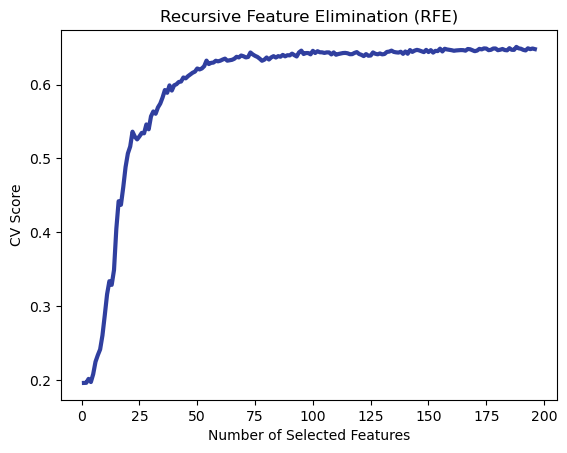

The optimal number of features: 188


In [82]:
plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"], color='#303F9F', linewidth=3)
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()
print("The optimal number of features: {}".format(rfecv.n_features_))

Make a new DataFrame called "X_rfe" that contains selected features.

In [83]:
reduced_df_cor = np.array(reduced_df_cor, dtype=np.float32)

In [84]:
X_rfe = reduced_df_cor[:, rfecv.support_]

In [85]:
X_rfe.shape

(1400, 188)

In [86]:
estimator.fit(X_rfe, y_tr)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          random_state=42, subsample=0.5)

In [87]:
y_pred_CV_GBR = cross_val_predict(estimator, X_rfe, y_tr, cv=cv, n_jobs=-1)

In [88]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_GBR), 2)
Q2_CV

0.65

In [89]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_GBR)), 2)
RMSE_CV

0.72

In [90]:
reduced_df_cor=x_tr_const_and_nearcont.drop(to_drop, axis=1)

In [91]:
feature_idx = rfecv.get_support()
feature_name_rfecv = reduced_df_cor.columns[feature_idx]
feature_name_rfecv

Index(['KRFP1', 'KRFP2', 'KRFP14', 'KRFP16', 'KRFP20', 'KRFP92', 'KRFP126',
       'KRFP297', 'KRFP298', 'KRFP302',
       ...
       'KRFP4294', 'KRFP4295', 'KRFP4317', 'KRFP4479', 'KRFP4525', 'KRFP4695',
       'KRFP4752', 'KRFP4770', 'KRFP4835', 'KRFP4843'],
      dtype='object', length=188)

In [92]:
desc_name_rfecv=list(feature_name_rfecv)

In [235]:
from pathlib import Path

In [236]:
urls=list(feature_name_rfecv)

In [239]:
path = Path('feature_name_rfecv_KRFPFP.txt')

In [240]:
path.write_text('\n'.join(urls))

1639

# Prediction for test set's molecules

In [95]:
x_ts=desc_ts[feature_name_rfecv]

In [96]:
y_ts = np.array(y_ts, dtype=np.float32)

In [97]:
y_pred_GBR = estimator.predict(x_ts)

In [98]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.7

In [99]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.67

# save the model to disk

In [94]:
pickle.dump(estimator, open('Models/Padels/HDAC3_GBR_KRFPFP_final_FS.pkl', 'wb'))

# load the model from disk

In [100]:
best_GBR = pickle.load(open('Models/Padels/HDAC3_GBR_KRFPFP_final_FS.pkl', 'rb'))

# Y-randomization GradientBoostingRegressor model

In [102]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_GBR, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(2),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.7min


True score =  0.65 
Y-randomization =  -0.37 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.1min finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [103]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [104]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.414214,2.645751,2.000000,0.000000,1.414214,1.414214,1.414214,5.000000,2.645751,3.464102,...,2.645751,2.000000,1.000000,1.000000,2.000000,2.236068,1.000000,1.000000,2.828427,1.000000
2,1.732051,3.464102,3.872983,0.000000,3.741657,1.732051,2.236068,5.099020,2.645751,3.464102,...,3.605551,2.000000,1.000000,1.000000,2.236068,2.449490,1.000000,1.000000,2.828427,1.414214
3,1.732051,3.464102,4.242640,1.000000,4.358899,2.236068,2.645751,5.099020,2.645751,3.464102,...,3.605551,2.236068,1.000000,1.000000,2.449490,2.449490,1.414214,1.414214,3.162278,1.414214
4,1.732051,3.605551,4.358899,1.732051,4.582576,2.236068,2.645751,5.196152,2.828427,4.000000,...,3.741657,2.449490,1.000000,1.000000,2.449490,2.645751,1.414214,1.414214,3.316625,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.944272,9.110434,8.774964,8.660254,8.602325,9.486833,8.660254,8.774964,9.899495,9.539392,...,9.539392,9.327379,9.433981,9.380832,9.591663,9.486833,9.380832,9.327379,8.717798,9.273619
1396,9.000000,9.110434,8.774964,8.717798,8.660254,9.486833,8.660254,8.831760,9.949874,9.539392,...,9.539392,9.327379,9.433981,9.380832,9.591663,9.486833,9.433981,9.327379,8.774964,9.327379
1397,9.055386,9.165152,8.888194,8.717798,8.660254,9.539392,8.660254,8.831760,10.049875,9.539392,...,9.695360,9.327379,9.433981,9.433981,9.591663,9.486833,9.433981,9.380832,8.831760,9.327379
1398,9.055386,9.165152,9.055386,8.774964,8.660254,9.539392,8.717798,8.888194,10.049875,9.539392,...,9.695360,9.380832,9.433981,9.433981,9.591663,9.539392,9.433981,9.380832,8.888194,9.327379


In [105]:
similarity= neighbors_k

In [106]:
Dmean=np.mean(similarity[1,:])

In [107]:
round(Dmean, 2)

1.74

In [108]:
std=np.std(similarity[1,:])

In [109]:
round(std, 2)

1.2

In [110]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.34


In [111]:
x_ts=desc_ts[feature_name_rfecv]

In [112]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [113]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,2.449490,4.472136,1.732051,1.732051,2.000000,1.732051,2.236068,2.828427,2.000000,...,0.000000,1.414214,1.000000,0.000000,2.828427,1.000000,1.000000,1.732051,2.449490,2.645751
1,2.645751,3.464102,4.690416,3.316625,2.645751,2.645751,2.645751,2.449490,3.316625,2.645751,...,1.000000,2.000000,1.414214,1.414214,3.000000,1.414214,1.000000,1.732051,2.449490,2.828427
2,3.000000,3.605551,4.898979,3.464102,3.000000,2.828427,2.828427,2.449490,4.358899,3.162278,...,1.414214,2.236068,1.732051,1.732051,3.000000,1.414214,1.000000,1.732051,2.449490,3.000000
3,3.000000,3.605551,4.898979,3.605551,3.316625,3.605551,2.828427,3.741657,4.690416,3.162278,...,1.414214,2.449490,1.732051,1.732051,3.162278,1.732051,1.414214,2.000000,2.645751,3.000000
4,3.162278,3.741657,5.000000,4.795832,4.000000,3.741657,2.828427,4.123106,4.898979,3.605551,...,1.414214,2.449490,1.732051,1.732051,3.162278,1.732051,1.414214,2.000000,2.645751,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,9.055385,9.433981,8.660254,9.695360,9.055385,9.110434,9.949874,9.110434,9.380832,9.219544,...,9.273618,9.433981,9.273618,9.433981,9.539392,9.327379,9.380832,9.486833,9.591663,9.695360
1396,9.110434,9.486833,8.660254,9.797959,9.055385,9.110434,10.000000,9.165151,9.380832,9.219544,...,9.327379,9.433981,9.273618,9.433981,9.591663,9.327379,9.380832,9.486833,9.591663,9.695360
1397,9.110434,9.591663,8.717798,9.848858,9.055385,9.165151,10.099505,9.165151,9.433981,9.380832,...,9.433981,9.433981,9.380832,9.433981,9.591663,9.327379,9.380832,9.486833,9.695360,9.695360
1398,9.110434,9.591663,8.774964,9.848858,9.055385,9.165151,10.099505,9.219544,9.433981,9.380832,...,9.433981,9.486833,9.433981,9.433981,9.591663,9.327379,9.380832,9.539392,9.695360,9.797959


In [114]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    2.449 4.472 1.732 1.732 2.    1.732 2.236 2.828 2.    3.873 2.
 1.    2.    2.    1.414 1.    2.449 3.873 1.414 1.414 2.646 4.69  1.
 1.732 1.732 2.646 2.236 1.414 1.    4.69  0.    3.    1.414 1.    1.414
 1.732 1.414 1.414 1.414 1.414 5.292 2.828 1.    1.414 1.    3.742 2.646
 1.732 1.732 2.    3.    2.    1.414 1.732 3.742 1.414 1.414 1.    2.
 0.    3.317 1.732 3.606 2.828 1.414 3.873 0.    2.    4.    3.317 1.732
 0.    1.    1.414 1.732 1.414 2.236 2.828 2.449 0.    1.    2.    1.414
 1.    1.    0.    1.732 0.    5.    2.236 5.    1.414 2.    1.732 2.828
 1.414 2.449 0.    1.732 5.196 1.    0.    1.    2.    1.414 4.243 1.414
 1.732 1.    1.    2.236 1.732 1.    1.732 2.449 1.732 2.    2.236 0.
 2.646 3.    2.449 2.    2.449 2.646 1.732 1.414 1.    3.464 2.236 2.828
 1.    2.646 1.    1.732 1.414 1.732 2.236 2.    3.873 1.    2.    1.
 1.414 2.236 1.414 1.414 0.    3.742 1.732 1.    1.732 1.414 2.449 2.646
 1.414 1.732 1.    1.414 1.    0.    1.732 1.414 1.732 0.    1.   

In [115]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True  True  True  True False  True False  True
  True  True  True  True  True False False  True  True False False  True
  True  True False  True  True  True False  True False  True  True  True
  True  True  True  True  True False False  True  True  True False False
  True  True  True False  True  True  True False  True  True  True  True
  True False  True False False  True False  True  True False False  True
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True False  True False  True  True  True False
  True False  True  True False  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True  True  True
 False False False  True False False  True  True  True False  True False
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False  True  True  True  True False False
  True  True  True  True  True  True  True  True  T

In [116]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [117]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   5   6   7   9  11  12  13  14  15  16  19  20  23  24  25
  27  28  29  31  33  34  35  36  37  38  39  40  43  44  45  48  49  50
  52  53  54  56  57  58  59  60  62  65  67  68  71  72  73  74  75  76
  77  80  81  82  83  84  85  86  87  88  90  92  93  94  96  98  99 101
 102 103 104 105 107 108 109 110 111 112 113 114 116 117 118 119 123 126
 127 128 130 132 134 135 136 137 138 139 141 142 143 144 145 146 147 148
 150 151 152 153 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 178 179 180 183 184 185 186 187 188 189 190 191
 192 193 194 195 197 198 199 201 202 203 204 206 210 211 212 213 214 215
 216 217 218 220 221 222 223 224 225 226 227 228 230 232 233 234 235 237
 238 239 240 242 244 246 247 248 249 250 251 252 254 255 256 257 258 259
 260 261 263 264 265 266 267 268 269 270 274 275 277 280 281 282 283 284
 286 287 289 291 292 295 296 297 298 299 301 303 304 305 306 307 308 310
 311 312 31

In [118]:
out_Ad=list(np.where(cpd_AD == 0)[0])

#  Prediction only for molecules included in  AD

In [119]:
y_pred_GBR_ad=list(y_pred_GBR)

In [120]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [121]:
len(y_pred_GBR_ad)

266

In [122]:
y_ts_ad=list(y_ts)

In [123]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [124]:
len(y_ts_ad)

266

In [125]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.76

In [126]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.6

# SVM model building and validation

In [127]:
from sklearn.svm import SVR

In [128]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [129]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [130]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [131]:
svm.fit(X_rfe, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVR(epsilon=0.2), n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]},
             verbose=1)

In [132]:
svm.best_params_
best_svm = svm.best_estimator_

In [133]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [134]:
y_pred_CV_svm = cross_val_predict(best_svm, X_rfe, y_tr, cv=cv)

In [135]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.63

In [136]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.74

#  Prediction for test set's molecules

In [137]:
x_ts = np.array(x_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [138]:
y_pred_svm = best_svm.predict(x_ts)

In [139]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.63

In [140]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.75

save the model to disk

In [171]:
pickle.dump(best_svm, open('Models/Padels/HDAC3_SVM_KRFPFP.pkl', 'wb'))

load the model from disk

In [172]:
best_svm = pickle.load(open('Models/Padels/HDAC3_SVM_KRFPFP.pkl', 'rb'))

# 10. Y-randomization SVM model

In [173]:
permutations = 50
score, permutation_scores, pvalue = permutation_test_score(best_svm, X_rfe, y_tr,
                                                           cv=cv, scoring='r2',
                                                           n_permutations=permutations,
                                                           n_jobs=-1,
                                                           verbose=1,
                                                           random_state=seed)
print('True score = ', score.round(3),
      '\nY-randomization = ', np.mean(permutation_scores).round(2),
      '\np-value = ', pvalue.round(4))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.9s


True score =  0.631 
Y-randomization =  -0.17 
p-value =  0.0196


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [174]:
neighbors_k= pairwise_distances(X_rfe, n_jobs=-1)
neighbors_k.sort(0)

In [175]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.414214,2.645751,2.000000,0.000000,1.414214,1.414214,1.414214,5.000000,2.645751,3.464102,...,2.645751,2.000000,1.000000,1.000000,2.000000,2.236068,1.000000,1.000000,2.828427,1.000000
2,1.732051,3.464102,3.872983,0.000000,3.741657,1.732051,2.236068,5.099020,2.645751,3.464102,...,3.605551,2.000000,1.000000,1.000000,2.236068,2.449490,1.000000,1.000000,2.828427,1.414214
3,1.732051,3.464102,4.242640,1.000000,4.358899,2.236068,2.645751,5.099020,2.645751,3.464102,...,3.605551,2.236068,1.000000,1.000000,2.449490,2.449490,1.414214,1.414214,3.162278,1.414214
4,1.732051,3.605551,4.358899,1.732051,4.582576,2.236068,2.645751,5.196152,2.828427,4.000000,...,3.741657,2.449490,1.000000,1.000000,2.449490,2.645751,1.414214,1.414214,3.316625,1.414214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,8.944272,9.110434,8.774964,8.660254,8.602325,9.486833,8.660254,8.774964,9.899495,9.539392,...,9.539392,9.327379,9.433981,9.380832,9.591663,9.486833,9.380832,9.327379,8.717798,9.273619
1396,9.000000,9.110434,8.774964,8.717798,8.660254,9.486833,8.660254,8.831760,9.949874,9.539392,...,9.539392,9.327379,9.433981,9.380832,9.591663,9.486833,9.433981,9.327379,8.774964,9.327379
1397,9.055386,9.165152,8.888194,8.717798,8.660254,9.539392,8.660254,8.831760,10.049875,9.539392,...,9.695360,9.327379,9.433981,9.433981,9.591663,9.486833,9.433981,9.380832,8.831760,9.327379
1398,9.055386,9.165152,9.055386,8.774964,8.660254,9.539392,8.717798,8.888194,10.049875,9.539392,...,9.695360,9.380832,9.433981,9.433981,9.591663,9.539392,9.433981,9.380832,8.888194,9.327379


In [176]:
similarity= neighbors_k

In [177]:
Dmean=np.mean(similarity[1,:])

In [178]:
round(Dmean, 2)

1.74

In [179]:
std=np.std(similarity[1,:])

In [180]:
round(std, 2)

1.2

In [181]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.34


In [182]:
x_ts=desc_ts[feature_name_rfecv]

In [183]:
neighbors_k_ts= pairwise_distances(X_rfe,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [184]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,341,342,343,344,345,346,347,348,349,350
0,0.000000,2.449490,4.472136,1.732051,1.732051,2.000000,1.732051,2.236068,2.828427,2.000000,...,0.000000,1.414214,1.000000,0.000000,2.828427,1.000000,1.000000,1.732051,2.449490,2.645751
1,2.645751,3.464102,4.690416,3.316625,2.645751,2.645751,2.645751,2.449490,3.316625,2.645751,...,1.000000,2.000000,1.414214,1.414214,3.000000,1.414214,1.000000,1.732051,2.449490,2.828427
2,3.000000,3.605551,4.898979,3.464102,3.000000,2.828427,2.828427,2.449490,4.358899,3.162278,...,1.414214,2.236068,1.732051,1.732051,3.000000,1.414214,1.000000,1.732051,2.449490,3.000000
3,3.000000,3.605551,4.898979,3.605551,3.316625,3.605551,2.828427,3.741657,4.690416,3.162278,...,1.414214,2.449490,1.732051,1.732051,3.162278,1.732051,1.414214,2.000000,2.645751,3.000000
4,3.162278,3.741657,5.000000,4.795832,4.000000,3.741657,2.828427,4.123106,4.898979,3.605551,...,1.414214,2.449490,1.732051,1.732051,3.162278,1.732051,1.414214,2.000000,2.645751,3.162278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,9.055385,9.433981,8.660254,9.695360,9.055385,9.110434,9.949874,9.110434,9.380832,9.219544,...,9.273618,9.433981,9.273618,9.433981,9.539392,9.327379,9.380832,9.486833,9.591663,9.695360
1396,9.110434,9.486833,8.660254,9.797959,9.055385,9.110434,10.000000,9.165151,9.380832,9.219544,...,9.327379,9.433981,9.273618,9.433981,9.591663,9.327379,9.380832,9.486833,9.591663,9.695360
1397,9.110434,9.591663,8.717798,9.848858,9.055385,9.165151,10.099505,9.165151,9.433981,9.380832,...,9.433981,9.433981,9.380832,9.433981,9.591663,9.327379,9.380832,9.486833,9.695360,9.695360
1398,9.110434,9.591663,8.774964,9.848858,9.055385,9.165151,10.099505,9.219544,9.433981,9.380832,...,9.433981,9.486833,9.433981,9.433981,9.591663,9.327379,9.380832,9.539392,9.695360,9.797959


In [185]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[0.    2.449 4.472 1.732 1.732 2.    1.732 2.236 2.828 2.    3.873 2.
 1.    2.    2.    1.414 1.    2.449 3.873 1.414 1.414 2.646 4.69  1.
 1.732 1.732 2.646 2.236 1.414 1.    4.69  0.    3.    1.414 1.    1.414
 1.732 1.414 1.414 1.414 1.414 5.292 2.828 1.    1.414 1.    3.742 2.646
 1.732 1.732 2.    3.    2.    1.414 1.732 3.742 1.414 1.414 1.    2.
 0.    3.317 1.732 3.606 2.828 1.414 3.873 0.    2.    4.    3.317 1.732
 0.    1.    1.414 1.732 1.414 2.236 2.828 2.449 0.    1.    2.    1.414
 1.    1.    0.    1.732 0.    5.    2.236 5.    1.414 2.    1.732 2.828
 1.414 2.449 0.    1.732 5.196 1.    0.    1.    2.    1.414 4.243 1.414
 1.732 1.    1.    2.236 1.732 1.    1.732 2.449 1.732 2.    2.236 0.
 2.646 3.    2.449 2.    2.449 2.646 1.732 1.414 1.    3.464 2.236 2.828
 1.    2.646 1.    1.732 1.414 1.732 2.236 2.    3.873 1.    2.    1.
 1.414 2.236 1.414 1.414 0.    3.742 1.732 1.    1.732 1.414 2.449 2.646
 1.414 1.732 1.    1.414 1.    0.    1.732 1.414 1.732 0.    1.   

In [186]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[ True False False  True  True  True  True  True False  True False  True
  True  True  True  True  True False False  True  True False False  True
  True  True False  True  True  True False  True False  True  True  True
  True  True  True  True  True False False  True  True  True False False
  True  True  True False  True  True  True False  True  True  True  True
  True False  True False False  True False  True  True False False  True
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True False  True False  True  True  True False
  True False  True  True False  True  True  True  True  True False  True
  True  True  True  True  True  True  True False  True  True  True  True
 False False False  True False False  True  True  True False  True False
  True False  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True False  True  True  True  True False False
  True  True  True  True  True  True  True  True  T

In [187]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [188]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  0   3   4   5   6   7   9  11  12  13  14  15  16  19  20  23  24  25
  27  28  29  31  33  34  35  36  37  38  39  40  43  44  45  48  49  50
  52  53  54  56  57  58  59  60  62  65  67  68  71  72  73  74  75  76
  77  80  81  82  83  84  85  86  87  88  90  92  93  94  96  98  99 101
 102 103 104 105 107 108 109 110 111 112 113 114 116 117 118 119 123 126
 127 128 130 132 134 135 136 137 138 139 141 142 143 144 145 146 147 148
 150 151 152 153 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 178 179 180 183 184 185 186 187 188 189 190 191
 192 193 194 195 197 198 199 201 202 203 204 206 210 211 212 213 214 215
 216 217 218 220 221 222 223 224 225 226 227 228 230 232 233 234 235 237
 238 239 240 242 244 246 247 248 249 250 251 252 254 255 256 257 258 259
 260 261 263 264 265 266 267 268 269 270 274 275 277 280 281 282 283 284
 286 287 289 291 292 295 296 297 298 299 301 303 304 305 306 307 308 310
 311 312 31

In [189]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [190]:
y_pred_svm_ad=list(y_pred_svm)

In [191]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [192]:
len(y_pred_svm_ad)

266

In [193]:
y_ts_ad=list(y_ts)

In [194]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [195]:
len(y_ts_ad)

266

In [196]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.67

In [197]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.7

## Analyzing the importance of descriptors for the GBM model

In [214]:
desc_for_analisis_ws=reduced_df_cor[feature_name_rfecv]
desc_for_analisis_ws

,KRFP1,KRFP2,KRFP14,KRFP16,KRFP20,KRFP92,KRFP126,KRFP297,KRFP298,KRFP302,...,KRFP4294,KRFP4295,KRFP4317,KRFP4479,KRFP4525,KRFP4695,KRFP4752,KRFP4770,KRFP4835,KRFP4843
0,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,1,0
1,1,0,0,0,1,0,0,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,0,1,1,1,1,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1396,1,0,0,1,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1397,1,0,0,1,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
1398,1,0,0,1,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [233]:
number_feature=125
index = number_feature-1
column_name = desc_for_analisis_ws.columns[index]
print(column_name)

KRFP3721


In [204]:
X_rfe.shape

(1400, 188)

In [201]:
import shap

In [205]:
explainer = shap.Explainer(best_GBR)

In [206]:
shap_values = explainer(X_rfe)

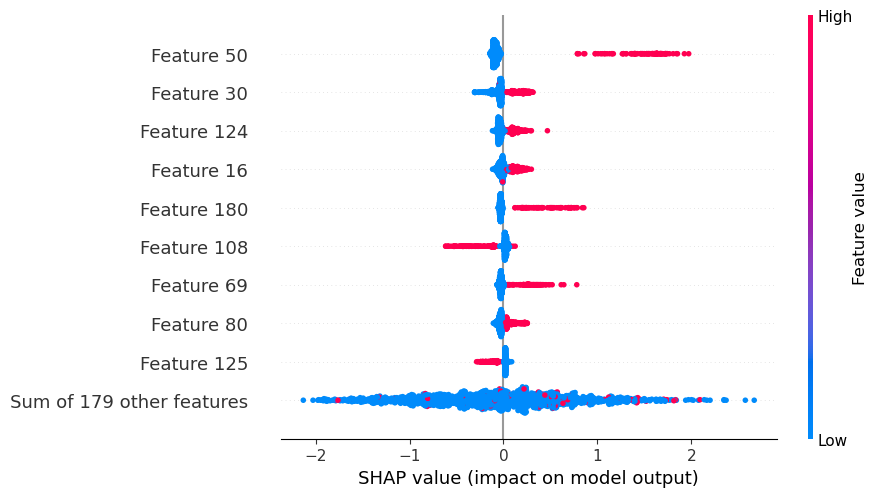

In [207]:
shap.plots.beeswarm(shap_values)

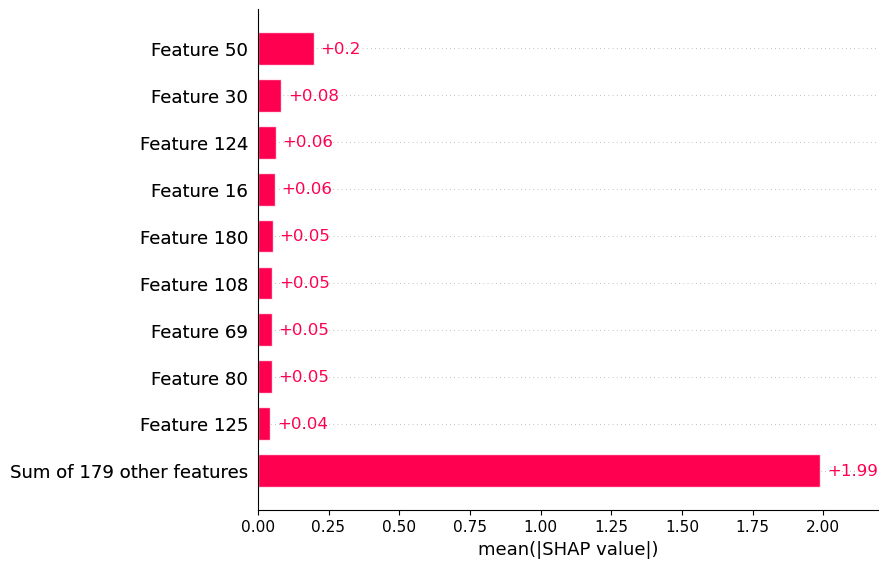

In [208]:
shap.plots.bar(shap_values)